## Import Dependencies

In [1]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

C:\Users\USER\miniconda3\envs\yolov7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
## Random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) # for Multi_GPUs

In [4]:
# C:\\Users\\Komil\\Desktop\\LicensePlateDetection\\licensedata
#C:\Users\USER\Desktop\MrShahrullo\project

In [5]:
# PATH FOR DATASET
PATH = 'C:\\Users\\USER\Desktop\\MrShahrullo\\project'
PATH_ANNS = os.path.join(PATH, 'annotations')  
PATH_IMGS = os.path.join(PATH, 'images_data')

In [6]:
import glob

list_anns = glob.glob('C:\\Users\\USER\Desktop\\MrShahrullo\\project\\annotations\\*.xml')
list_imgs = glob.glob('C:\\Users\\USER\Desktop\\MrShahrullo\\project\\images_data\\*')

In [7]:
list_imgs[0]

'C:\\Users\\USER\\Desktop\\MrShahrullo\\project\\images_data\\Cars0.png'

In [8]:
list_anns[0]

'C:\\Users\\USER\\Desktop\\MrShahrullo\\project\\annotations\\Cars0.xml'

## Convert XML to YOLOv format - TXT

In [9]:
# Function to get the data from XML files
def extract_info_from_xml(xml_file):
    
    root = ET.parse(xml_file).getroot()
    
    # Initialize the info dict
    info_dict = {}
    info_dict['bboxes'] = []
    
    # Parse the XML Tree
    for elem in root:
        # Get the filename
        if elem.tag == 'filename':
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == 'size':
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
                
            info_dict['image_size'] = tuple(image_size)
            
        # Get details of bounding box
        elif elem.tag == 'object':
            bbox = {}
            for subelem in elem:
                if subelem.tag == 'name':
                    bbox['class'] = subelem.text
                    
                elif subelem.tag == 'bndbox':
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)
            
    return info_dict

In [10]:
print(extract_info_from_xml(list_anns[0]))

{'bboxes': [{'class': 'licence', 'xmin': 226, 'ymin': 125, 'xmax': 419, 'ymax': 173}], 'filename': 'Cars0.png', 'image_size': (500, 268, 3)}


In [11]:
# Mapping annotations with dict
class_name_to_id_mapping = {'licence': 0,}

In [12]:
# Convert the info dict to the YOLO format and write it to disk
def XML_to_TXT(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict['bboxes']:
        try:
            class_id = class_name_to_id_mapping[b['class']]
        except KeyError:
            print('Invalid Class. Must be one from', class_name_to_id_mapping.keys())
         
        # Transform the bbox co-ordinates as per the YOLO format  
        b_center_x = (b['xmin'] + b['xmax']) / 2
        b_center_y = (b['ymin'] + b['ymax']) / 2
        b_width = (b['xmax'] - b['xmin'])
        b_height = (b['ymax'] - b['ymin'])
        
        # Normalize by the dimension of the image
        image_w, image_h, image_c = info_dict['image_size']
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h
        
        # Write the bbox to the file
        print_buffer.append('{} {:.3f} {:.3f} {:.3f} {:.3f}'.format(class_id, b_center_x, b_center_y, b_width, b_height))
                            
    # Name of the file which to save
    save_file_name = os.path.join(PATH_ANNS, info_dict['filename'].replace('png', 'txt'))
    
    # Save the annotation to disk
    print('\n'.join(print_buffer), file=open(save_file_name, 'w'))

In [13]:
# Sort the annotations
list_anns.sort()

# Convert and safe the anns
for ann in tqdm(list_anns):
    info_dict = extract_info_from_xml(ann)
    XML_to_TXT(info_dict)

100%|██████████| 433/433 [00:01<00:00, 352.48it/s]


In [14]:
# list_anns_txt = glob.glob('DATASETS/CarLicensePlateDetection_Kaggle/annotations/*.txt')
list_anns_txt = [os.path.join(PATH_ANNS, x) for x in os.listdir(PATH_ANNS) if x[-3:] == 'txt']

In [15]:
len(list_anns_txt)

433

In [16]:
list_anns_txt[:5] # yolo faqat txt format qabul qiladi.

['C:\\Users\\USER\\Desktop\\MrShahrullo\\project\\annotations\\Cars0.txt',
 'C:\\Users\\USER\\Desktop\\MrShahrullo\\project\\annotations\\Cars1.txt',
 'C:\\Users\\USER\\Desktop\\MrShahrullo\\project\\annotations\\Cars10.txt',
 'C:\\Users\\USER\\Desktop\\MrShahrullo\\project\\annotations\\Cars100.txt',
 'C:\\Users\\USER\\Desktop\\MrShahrullo\\project\\annotations\\Cars101.txt']

### Testing Anns

In [17]:
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

In [18]:
def plot_bbox(image, anns):
    anns = np.array(anns)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)
    
    transformed_anns = np.copy(anns)
    transformed_anns[:, [1, 3]] = anns[:, [1, 3]] * w
    transformed_anns[:, [2, 4]] = anns[:, [2, 4]] * h
    
    transformed_anns[:, 1] = transformed_anns[:, 1] - (transformed_anns[:, 3] / 2)
    transformed_anns[:, 2] = transformed_anns[:, 2] - (transformed_anns[:, 4] / 2)
    transformed_anns[:, 3] = transformed_anns[:, 1] + transformed_anns[:, 3]
    transformed_anns[:, 4] = transformed_anns[:, 2] + transformed_anns[:, 4]
    
    for ann in transformed_anns:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0, y0), (x1, y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
        
    plt.imshow(np.array(image))
    plt.show()

In [19]:
# Get any random ann file
random.seed(5)

ann_file = random.choice(list_anns_txt)
with open(ann_file, 'r') as f:
    ann_list = f.read().split('\n')[:-1]
    ann_list = [x.split(' ') for x in ann_list]
    ann_list = [[float(y) for y in x] for x in ann_list]

In [20]:
# Get the coresponding image file
image_file = ann_file.replace(PATH_ANNS, PATH_IMGS).replace('txt', 'png')
assert os.path.exists(image_file)

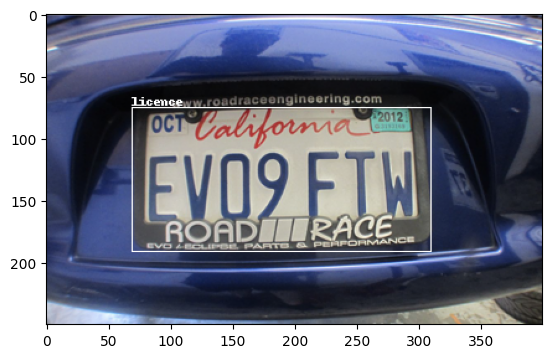

In [21]:
# Load the image
image = Image.open(image_file)

# Plot bbox
plot_bbox(image, ann_list)

In [22]:
# Read images and labels
images = [os.path.join(PATH_IMGS, x) for x in os.listdir(PATH_IMGS)]
labels = [os.path.join(PATH_ANNS, x) for x in os.listdir(PATH_ANNS) if x[-3:] == 'txt']

In [23]:
images[0]

'C:\\Users\\USER\\Desktop\\MrShahrullo\\project\\images_data\\Cars0.png'

In [24]:
list_imgs.sort()
labels.sort()

In [25]:
# Split the dataset
train_images, val_images, train_labels, val_labels = train_test_split(list_imgs, labels, test_size=0.3, random_state=1)
val_images, test_images, val_labels, test_labels = train_test_split(val_images, val_labels, test_size=0.5, random_state=1)

In [26]:
# function to move images to related folder
def move_files_to_folder(list_of_files, destination):
    for f in list_of_files:
        try:
            shutil.copy(f, destination)
        except:
            print(f)
            assert False

In [27]:
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val')
move_files_to_folder(test_images, 'images/test')
move_files_to_folder(train_labels, 'labels/train')
move_files_to_folder(val_labels, 'labels/val')
move_files_to_folder(test_labels, 'labels/test')

## Start Training

In [28]:
# Create yaml file for data

In [29]:
pwd

'C:\\Users\\USER\\Desktop\\MrShahrullo\\project'

In [30]:
cd yolov7

C:\Users\USER\Desktop\MrShahrullo\project\yolov7


In [31]:
pwd

'C:\\Users\\USER\\Desktop\\MrShahrullo\\project\\yolov7'

In [32]:
import torch
torch.cuda.is_available()

True

In [37]:
!python train.py --workers 6 --device 0 --batch-size 16 --data data/licence_data.yaml --img 448 448 --cfg cfg/training/yolov7.yaml --weights '' --name yolov7 --hyp data/hyp.scratch.p5.yaml --epochs 1500

wandb: Install Weights & Biases for YOLOR logging with 'pip install wandb' (recommended)

autoanchor: Analyzing anchors... anchors/target = 3.95, Best Possible Recall (BPR) = 1.0000
                 all          65          69     0.00152       0.174    0.000348    5.68e-05
                 all          65          69     0.00154       0.188    0.000385    5.97e-05
                 all          65          69     0.00159       0.203    0.000404    6.06e-05
                 all          65          69    0.000914       0.116    0.000191    4.23e-05
                 all          65          69     0.00155        0.13    0.000336    6.65e-05
                 all          65          69     0.00107       0.203    0.000337    6.25e-05
                 all          65          69     0.00109       0.188    0.000432    7.36e-05
                 all          65          69    0.000938       0.217    0.000415    5.47e-05
                 all          65          69      0.0042      0.0145    0.

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

